## Code used for cleaning up and organizing the log results from MOA Multithread Ensembles

- Run ./chunk_pre.sh <Folder with chunk logs\> > file.csv
- Import and show
- Functions format_table_excel_* will either print (show) or (copy to) clipboard a df in the suggested format for annalysis

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
import calendar
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

***
## Parsing preliminary results to find maximum rate and acc comparison

In [29]:
def parse_folder_to_file(folder, outfilename):
    %cd /home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/results/Energy/pi/1000/1000/first
    directory = os.fsencode(folder)
    header_printed = False

    with open(f"{outfilename}.csv", "w+") as output:
        output.write('dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change\n')
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("dump-"): 
                s = parse(f'{os.fsdecode(directory)}/{filename}')
                output.write(f"{s}\n")

In [30]:
def parse(fname):
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
#         if not header_printed:
#             head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
#             pstr = f"{head}\n{pstr}"
#             header_printed = True
        return (pstr[:-1])

In [31]:
%cd /home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/
# parse_folder_to_file('energy_pi/get_rates', 'scripts/data-pi')
# parse_folder_to_file('acc-small', '../scripts/data-acc')
# parse_folder_to_file('lbag-small-ens', '../scripts/lbag-acc')

/home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa


***
## Generating acc vs rate charts

In [32]:
def load_df(filename):
    df = pd.read_csv(filename)
    display(df)
    return select_columns_and_rename_values(df)

In [33]:
def select_columns_and_rename_values(df, columns=['dataset', 'algorithm', 'ensemble_size', 'cores', 'batch_size', 'instances', 'time', 'acc']):
    df = df.loc[:,columns]
    print(df.dtypes)
    df['algorithm'] = df["algorithm"].str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df["algorithm"].str.replace("ARF$", "ARFSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB+")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    return df

In [34]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [35]:
def plot(ax, dsdf, my_id, x):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    c1 = 'tab:red'
    c2 = 'tab:blue'
    ds = list(dsdf.dataset)[0]
    ax.set_title(f'{dsformalname[ds]}')
    ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='acc')
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.ensemble_size)
    ax.set_ylim(0,100)
    ax2 = ax.twinx()
    ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    ax2.tick_params(axis='y', labelcolor=c2)
    if int(my_id/2) == 1:
        ax.set_xlabel('Ensemble size')
    ax.set_ylabel('Accuracy %', color=c1)
    ax2.set_ylabel('IPS', color=c2)

In [55]:
def gen_graph_initial_peralg(df, display_df=False):
#     datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    datasets = ['elecNormNew']

    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    filename = f"pi-rates"
    for alg in algorithms:
        fig, axs = plt.subplots(2, 2, figsize=(15,10))
        dfalg = filter_by_substring_algorithm(df, alg)
        fig.suptitle(f'{alg}')
        for ds in datasets:
            dsdf = dfalg[(dfalg.dataset == ds) & (dfalg.cores == 1)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
#                 if alg == 'SRP':
                display(dsdf)
            my_id = datasets.index(ds)
            ax = axs[int(my_id/2)][my_id%2]
            plot(ax, dsdf, my_id, x)
        plt.savefig(f'{filename}.eps', bbox_inches='tight')

In [10]:
lacc = pd.read_csv("../scripts/lbag-acc.csv")
lbag = lacc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset', 'algorithm','ensemble_size'])
lbag.to_csv("../scripts/lbag-acc-ordered.csv", index=False)

In [47]:
acc = load_df('/home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/parsed_csvs/dell-get_rates.csv')
acc = acc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset','algorithm','ensemble_size'])
print(f'Accuracy variation from ensembles with 25 to 100 classifiers:\n\n{"dataset":12} {"algorithm":17} {"variation"}\n')
for ds in acc.dataset.unique():
    for alg in acc.algorithm.unique():
        aux = acc[(acc.dataset == ds) & (acc.algorithm == alg)]
        l = list(zip(aux.ensemble_size, aux.acc))
        print(f'{ds:12} {alg:17} {l[0][1] - l[-1][1]}')

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagAdwinExecutorRUNPER,50,4,1,1,"45,312.00",12.83,86.10,86.26,85.19,0.00
1,elecNormNew,OzaBagASHTExecutorMAXChunk,50,4,50,1,"45,312.00",6.12,79.25,79.47,77.74,0.00
2,elecNormNew,AdaptiveRandomForestExecutorRUNPER,50,4,1,1,"29,271.00",20.00,89.47,89.51,88.86,0.00
3,elecNormNew,StreamingRandomPatchesExecutorRUNPER,50,4,1,1,"16,455.00",20.00,91.63,91.63,91.39,0.00
4,elecNormNew,OzaBag,50,1,1,1,"45,312.00",7.42,82.66,82.35,82.04,0.00
5,elecNormNew,StreamingRandomPatches,50,1,1,1,"12,815.00",20.00,91.90,91.85,91.70,0.00
6,elecNormNew,OzaBagASHTExecutorRUNPER,50,4,1,1,"45,312.00",11.66,84.26,84.46,83.18,0.00
7,elecNormNew,OzaBagAdwinExecutorMAXChunk,50,4,50,1,"45,312.00",6.81,80.11,80.09,78.89,0.00
8,elecNormNew,OzaBagASHT,50,1,1,1,"45,312.00",9.18,83.49,83.90,82.20,0.00
9,elecNormNew,AdaptiveRandomForestExecutorMAXChunk,50,4,50,1,"42,200.00",20.00,79.88,79.60,78.96,0.00


dataset           object
algorithm         object
ensemble_size      int64
cores              int64
batch_size         int64
instances        float64
time             float64
acc              float64
dtype: object
Accuracy variation from ensembles with 25 to 100 classifiers:

dataset      algorithm         variation

elecNormNew  ARFMB+            0.0
elecNormNew  ARFRUNPER         0.0
elecNormNew  ARFSequential     0.0
elecNormNew  LBagMB+           0.0
elecNormNew  LBagRUNPER        0.0
elecNormNew  LBagSequential    0.0
elecNormNew  OBASHTMB+         0.0
elecNormNew  OBASHTRUNPER      0.0
elecNormNew  OBASHTSequential  0.0
elecNormNew  OBAdwinMB+        0.0
elecNormNew  OBAdwinRUNPER     0.0
elecNormNew  OBAdwinSequential 0.0
elecNormNew  OBMB+             0.0
elecNormNew  OBRUNPER          0.0
elecNormNew  OBSequential      0.0
elecNormNew  SRPMB+            0.0
elecNormNew  SRPRUNPER         0.0
elecNormNew  SRPSequential     0.0


In [48]:
df = load_df('/home/reginaldojunior/Documentos/UFscar/compare-dvfs-moa/parsed_csvs/dell-get_rates.csv')
df['IPS'] = df['instances'] / df['time']
df = df.sort_values(by=['dataset','algorithm','ensemble_size']).drop(columns=['acc'])
chart_ensem_size = df.join(acc.set_index(['dataset','algorithm','ensemble_size']), on=['dataset','algorithm','ensemble_size'])

,dataset,algorithm,ensemble_size,cores,batch_size,rate,instances,time,acc,prec,recall,change
0,elecNormNew,OzaBagAdwinExecutorRUNPER,50,4,1,1,"45,312.00",12.83,86.10,86.26,85.19,0.00
1,elecNormNew,OzaBagASHTExecutorMAXChunk,50,4,50,1,"45,312.00",6.12,79.25,79.47,77.74,0.00
2,elecNormNew,AdaptiveRandomForestExecutorRUNPER,50,4,1,1,"29,271.00",20.00,89.47,89.51,88.86,0.00
3,elecNormNew,StreamingRandomPatchesExecutorRUNPER,50,4,1,1,"16,455.00",20.00,91.63,91.63,91.39,0.00
4,elecNormNew,OzaBag,50,1,1,1,"45,312.00",7.42,82.66,82.35,82.04,0.00
5,elecNormNew,StreamingRandomPatches,50,1,1,1,"12,815.00",20.00,91.90,91.85,91.70,0.00
6,elecNormNew,OzaBagASHTExecutorRUNPER,50,4,1,1,"45,312.00",11.66,84.26,84.46,83.18,0.00
7,elecNormNew,OzaBagAdwinExecutorMAXChunk,50,4,50,1,"45,312.00",6.81,80.11,80.09,78.89,0.00
8,elecNormNew,OzaBagASHT,50,1,1,1,"45,312.00",9.18,83.49,83.90,82.20,0.00
9,elecNormNew,AdaptiveRandomForestExecutorMAXChunk,50,4,50,1,"42,200.00",20.00,79.88,79.60,78.96,0.00


dataset           object
algorithm         object
ensemble_size      int64
cores              int64
batch_size         int64
instances        float64
time             float64
acc              float64
dtype: object


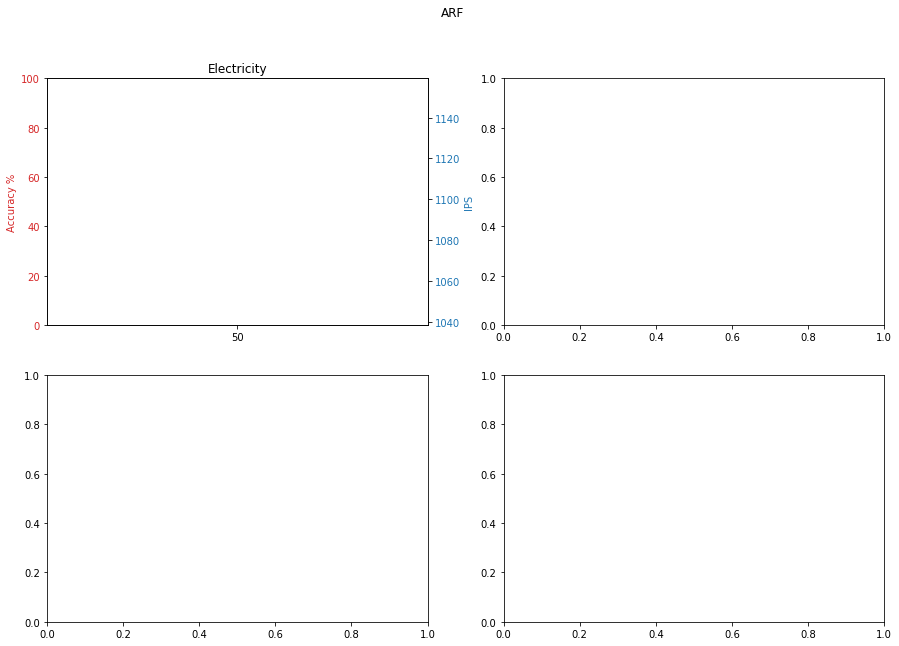

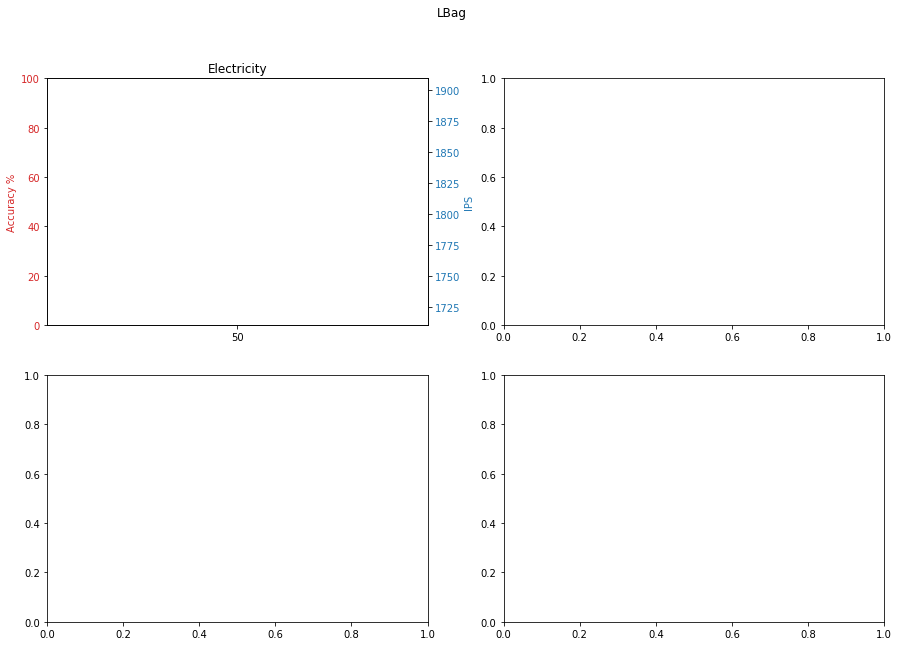

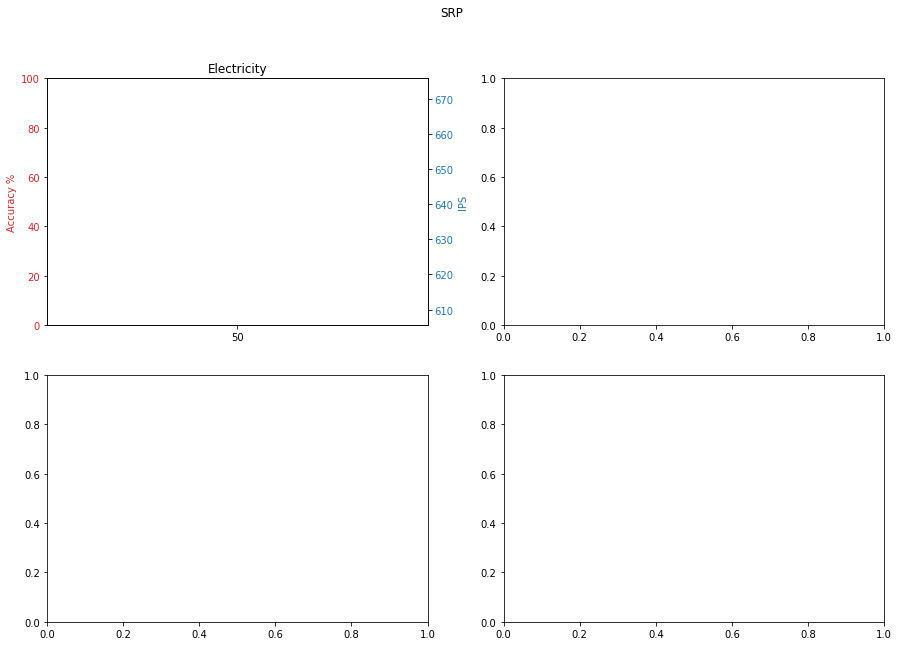

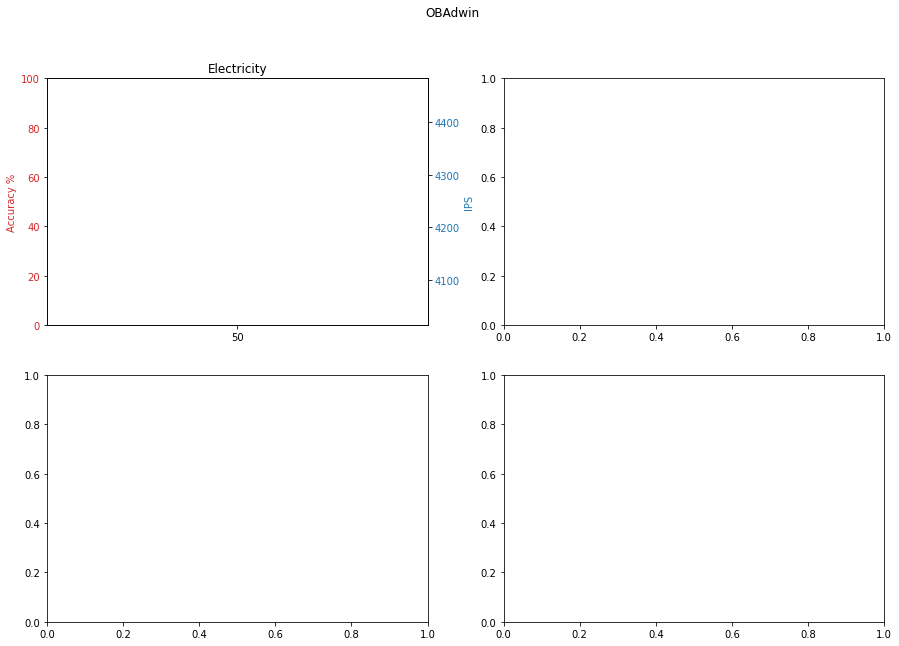

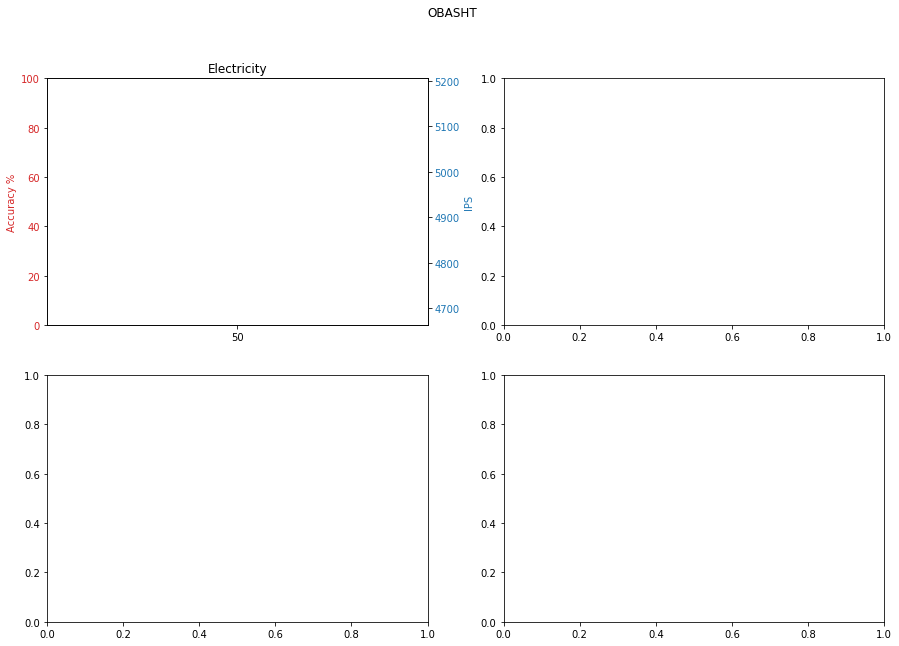

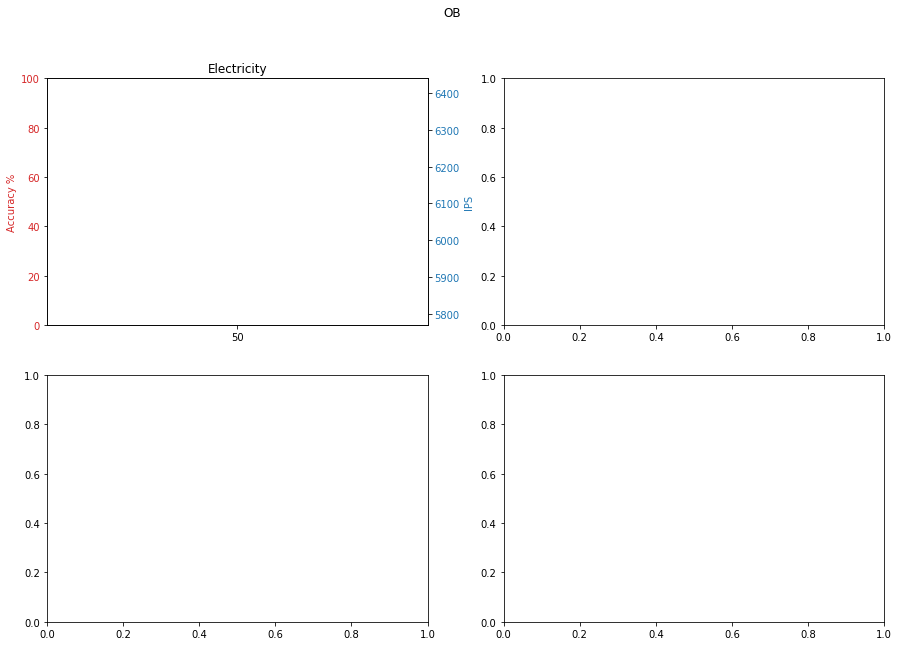

In [56]:
gen_graph_initial_peralg(chart_ensem_size, display_df=False)

## Finding rate

In [52]:
def calculate_rate(desired_esize):
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    file_algs = {'ARF': 'ARF', 'LBag': 'LBag', 'SRP': 'SRP', 'OBAdwin': 'OBagAd', 'OBASHT':'OBagASHT', 'OB': 'OBag'}
    for ds in df.dataset.unique():
        dsdf = df[df.dataset == ds]
        for alg in algorithms:
            s = f'X $1{ds}.arff {file_algs[alg]}'
            adf = filter_by_substring_algorithm(dsdf, alg)
#             if alg == 'SRP':
#                 display(adf)
            dfres = adf[adf.ensemble_size == desired_esize]
#             display(dfres)
            # get sequential
            seq_rate = list((dfres[(dfres.batch_size == 1) & (dfres.cores == 1)].IPS))[0]
            # get runper
            runper_rate = list(dfres[(dfres.batch_size == 1) & (dfres.cores != 1)].IPS)[0]
            # get MB
            mb_rate = list(dfres[(dfres.batch_size != 1) & (dfres.cores != 1)].IPS)[0]
            #we have max rates, now we need 10, 50 and 90
            if mb_rate != 'NaN':
                #10
                print(f'{s} {int(0.9*seq_rate)} {int(0.9*runper_rate)} {int(0.9*mb_rate)}')
                #50
                print(f'{s} {int(0.5*seq_rate)} {int(0.5*runper_rate)} {int(0.5*mb_rate)}')
                #90
                print(f'{s} {int(0.1*seq_rate)} {int(0.1*runper_rate)} {int(0.1*mb_rate)}')

In [53]:
print("Copy the following lines to the end of the script used to run the experimets\n")
calculate_rate(25)

Copy the following lines to the end of the script used to run the experimets



IndexError: list index out of range

# MOA logs

In [16]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [17]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [18]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [19]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        method = dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
#                 print(spline)
                if len(spline) == 7:
                    method,dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    method,dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
                if method not in d[algorithm]:
                    d[algorithm][method] = {}
                if dataset not in d[algorithm][method]:
                    d[algorithm][method][dataset] = {}
                if Esize not in d[algorithm][method][dataset]:
                    d[algorithm][method][dataset][Esize] = {}
                if cores not in d[algorithm][method][dataset][Esize]:
                    d[algorithm][method][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][method][dataset][Esize][cores]:
                    d[algorithm][method][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][method][dataset][Esize][cores][Bsize]:
                    d[algorithm][method][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][method][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [20]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            for k6, v6 in v5.items():
                                if 'seconds' not in v6:
                                    st = v6['start']
                                    ed = v6['finish']
                                    v6['seconds'] = (ed - st).seconds
                                    new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                              & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                    v6['avg_measure'] = new_df['measure'].mean()
                                    v6['sum_measure'] = new_df['measure'].sum()
                                    v6['avg_times_seconds'] = v6['avg_measure'] * v6['seconds']
    return d

In [21]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'method': [], 'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for k,v in d.items():
        for km,vm in v.items():
            for k1,v1 in vm.items():
                for k2,v2 in v1.items():
                    for k3,v3 in v2.items():
                        for k4,v4 in v3.items():
                            for k5,v5 in v4.items():
                                dappend['algorithm'].append(k)
                                dappend['method'].append(km)
                                dappend['dataset'].append(k1)
                                dappend['ensemble_size'].append(k2)
                                dappend['cores'].append(k3)
                                dappend['batch_size'].append(k4)
                                dappend['duration'].append(v5['seconds'])
                                dappend['inc_rate'].append(k5)
                                for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                    dappend[key].append(v5[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [22]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    dataset, alg, rate = line.split('-')[1:]
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# RUN MOTHERFUCKER

%cd pi
d = {}
df = load_Wmeas(f'energy/Wmeasure.log')
exper_order_to_dict(f'energy/exper_order.log')
d = populate_dict(d)
adf = append_dict_to_df(d, df)

In [23]:
%pwd

'/home/cassales/Documents/Parallel-Classifier-MOA/results'

In [24]:
d = {}
header_printed = False
moaDF = read_MOA("pi/energy/ChannelProd", "pi/energy/inst-and-delay.csv")
measureDF = load_Wmeas(f'pi/energy/Wmeasure_socket.log')
d = exper_order_to_dict(f'pi/energy/exper_order_socket.log', d)
populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'pi/energy/ChannelProd/ssh-log')

FileNotFoundError: [Errno 2] No such file or directory: 'pi/energy/inst-and-delay.csv'

In [ ]:
#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size'])
finaldf = finaldf.merge(sshDF, on=['algorithm', 'dataset', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
# finaldf['JP1kI'] = finaldf['joules'] / (finaldf['instances']/1000)
# finaldf['JPIoriginal'] = finaldf['JPI']
# finaldf['JPI'] = finaldf['JP1kI']
# finaldf

### Add PERC column to identify if it used 90, 50 or 10% max rate

In [ ]:
tdf = finaldf.sort_values(by=['dataset','algorithm','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
#         x = 1 if i % 3 == v else 0
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'
# tdf

### Show DFs for each algorithm and dataset, divided by rate

In [ ]:
algs = ['Ada', 'LB', 'Patch', 'Adwin', 'ASHT', 'OzaBag']
datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm']
for k in ['90', '50', '10']:
#     print(f"\n\n\n\n{k}")
    energy = tdf[tdf.PERC == k]
    for ds in energy.dataset.unique():
        for alg in algs:
#             auxdf = energy[(energy.dataset == ds) & (energy.algorithm.str.contains(alg))]
            auxdf = filter_by_substring_algorithm(energy[energy.dataset == ds], alg)
#             if alg == 'Patch' or alg == 'Ada':
#                 display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI', 'JP1kI']].sort_values(['cores','batch_size']))
#         auxdf = energy[(energy.dataset == ds) & (~energy.algorithm.str.contains('|'.join(algs)))]
#         display(auxdf[['algorithm','dataset','cores','batch_size','prod_rate','out_rate','instances','time','joules','JPI', 'JP1kI']].sort_values(['cores','batch_size']))

# Showing and preparing for graphs

In [ ]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [ ]:
def rename_columns_by_rate(df):
#     display(df)
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}",
                              "delay": f"delay_{rate}", "joules": f"joules_{rate}", "JPI": f"JPI_{rate}"})

In [ ]:
def my_norm(df, x='90MB'):
    mdf = df.iloc[:,[0,1,15,30,45]]
    if x == '90MB':
        thisisone = mdf.iloc[2,4]
#     else:
    elif x == '10S':
        thisisone = mdf.iloc[0,2]
    else:
#         10P
        thisisone = mdf.iloc[1,2]
    for i in ['JPI_10','JPI_50','JPI_90']:
           df[i] = df[i]/thisisone
#     display(df.iloc[:,[0,1,15,30,45]])
    return df.iloc[:,[0,1,15,30,45,7,22,37]]

linhas pretas (solida, tracejada, pontilhada)

JPI em barras (3 barras por rate)

In [ ]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.20
    alg_order = ['Sequential', 'B1', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':']
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    for i in range(3):
        adf = df.iloc[[i]]
        values_j = [adf.JPI_10.iloc[0], adf.JPI_50.iloc[0], adf.JPI_90.iloc[0]]
        if bar:
            lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
        else:
            lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
            
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
        
    if last:
        ax.set_ymargin(5)
    
    for i in range(3):
        adf = df.iloc[[i]]
        values_d = [x/1000 for x in [adf.delay_10.iloc[0], adf.delay_50.iloc[0], adf.delay_90.iloc[0]]]
        if bar:
            linfo = f'k{line_format[i]}'
        lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticks([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [ ]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            if rt == '10':
#                 display(dsalgdf)
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if alg == algs[-1]:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [ ]:
def gen_graph(bars=False, share_y='row', log_y=False, norm=False):
#     print(f'gen {bars}')
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    print(share_y)
    fig, axis = plt.subplots(len(datasets), 6, figsize=(12,9), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = tdf[tdf.dataset == ds]
#         if ds == 'kyoto_binary':
#             display(dsdf)
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=6, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=0.2)
    filename = 'bars-all-4x1-JPI-delay.eps' if bars else 'all-4x1-JPI-delay.eps'
    plt.savefig(f'Pi-{filename}', pad_inches=0.2, bbox_inches='tight')
#     plt.savefig(f'Pi-bars-all-5x1-JPI-delay.png', pad_inches=0.2)

gen_graph(bars=True)

In [ ]:
pd.options.display.max_columns = None

In [ ]:
def table_delta_rates_horizontal():
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    # filtra algoritmo
    for alg in algs:
#         line = alg + ' & $\Delta$ '
        line = alg + '  '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
        # filtra dataset
        for ds in datasets:
            dsalgdf = algdf[algdf.dataset == ds]
    #         display(dsalgdf.head())
            # "junta"
            for rt in rates:
                if rt == '10':
                    showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
                else:
                    to_join = dsalgdf[dsalgdf.PERC == rt]
                    showdf = showdf.merge(rename_columns_by_rate(to_join),on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
    #         showdf = showdf[['algorithm','dataset','cores','batch_size','JPI_10','JPI_50','JPI_90']]
    #         display(showdf)
            for i in ['10', '50', '90']:
                minoutro = min(showdf[showdf.batch_size == 1][f'JPI_{i}'])
    #             print(f"JPI_{i} minoutro {minoutro}")
                val = ((showdf[showdf.batch_size != 1][f'JPI_{i}'].iloc[0] - minoutro)/minoutro) * 100
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval}"
        print(f"{line} \\\\")

In [ ]:
def table_delta_rates_vert():
    all_values = []
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = 100 * ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')
    
    

In [ ]:
table_delta_rates_horizontal()

In [ ]:
table_delta_rates_vert()

Sharey = row

Linear scale

In [ ]:
# %cd ../..

In [ ]:
gen_graph(bars=True)

sharey = False

linear scale

In [ ]:
gen_graph(bars=True, share_y=False)

sharey = false

log scale y

In [ ]:
gen_graph(bars=True, share_y=False, log_y=True)

sharey = false

normalizado MB 90

In [ ]:
gen_graph(bars=True, share_y=False, log_y=False, norm='90MB')

sharey = false

normalizado Seq10

In [ ]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10S')

In [ ]:
gen_graph(bars=True, share_y=False, log_y=False, norm='10P')

## New chart, Ensemble_size vs (power consumption, accuracy, execution time)

In [ ]:
%pwd

In [ ]:
acc = pd.read_csv("../scripts/data-acc.csv")
acc = acc.loc[:,['dataset','algorithm','ensemble_size','acc']].sort_values(by=['dataset','algorithm','ensemble_size'])
# display(acc.head())
for ds in acc.dataset.unique():
    for alg in acc.algorithm.unique():
        aux = acc[(acc.dataset == ds) & (acc.algorithm == alg)]
        l = list(zip(aux.ensemble_size, aux.acc))
# df = load_df('../scripts/data-pi.csv')
df = pd.read_csv('../scripts/data-pi.csv')
df['IPS'] = df['instances'] / df['time']
df = df[df.cores == 1]
df = df.sort_values(by=['dataset','algorithm','ensemble_size']).drop(columns=['acc'])
df = df.join(acc.set_index(['dataset','algorithm','ensemble_size']), on=['dataset','algorithm','ensemble_size'])
# display(df.head())

measureDF = load_Wmeas(f'pi/more_batch_sizes/Wmeasure_sequential.log')
d = exper_order_to_dict(f'pi/more_batch_sizes/exper_order_sequential.log', d)
populate_dict(d, measureDF)
mdf = append_dict_to_df(d, True)
quero = mdf[(mdf.cores==1) & (mdf.inc_rate == 1)]
# display(quero.head())

fn = lambda row: row.avg_measure * row.duration
col = quero.apply(fn, axis=1) # get column data with an index
quero = quero.assign(avg_times_duration=col.values) # assign values to column 'c'
quero.ensemble_size = quero['ensemble_size'].astype('int64')
finaldf = df.merge(quero, on=['algorithm', 'dataset', 'ensemble_size', 'cores', 'batch_size'])
finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
# finaldf['JP1kI'] = finaldf['avg_times_duration'] / (finaldf['instances'] / 1000)
finaldf['JP1kI'] = finaldf['JPI']
finaldf = finaldf.sort_values(by=['dataset','algorithm','ensemble_size'])[['dataset', 'algorithm', 'ensemble_size', 'IPS', 'acc', 'JP1kI']]
finaldf.head()

add terceiro eixo

In [ ]:
def new_plot(ax, dsdf, my_id, x, fig):
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype', 'kyoto_binary': 'Kyoto'}
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    global twin1
    global twin2
    c1 = 'tab:red'
    c2 = 'tab:blue'
    c3 = 'tab:green'
    ax.set_title(f'{dsformalname[datasets[my_id]]}')
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    twin1=ax2
    twin2=ax3
    
#     offset = 60
#     new_fixed_axis = ax3.get_grid_helper().new_fixed_axis
#     ax3.axis["right"] = new_fixed_axis(loc="right", axes=ax2,
#                                         offset=(offset, 0))
#     
    ax3.spines["right"].set_position(("axes", 1.11))
    
    p1, = ax.plot(x, pd.to_numeric(dsdf.acc), color=c1, label='Accuracy')
    p2, = ax2.plot(x, pd.to_numeric(dsdf.IPS), color=c2, label='IPS')
    p3, = ax3.plot(x, pd.to_numeric(dsdf.JP1kI), color=c3, label='JPI')
    
    ax.tick_params(axis='y', labelcolor=c1)
    ax.set_xticks(x)
    ax.set_xticklabels(dsdf.ensemble_size)
    ax.set_ylim(0,100)
#     ax.set_ylabel('Accuracy %', color=c1)
    
    ax2.tick_params(axis='y', labelcolor=c2)
#     ax2.set_ylabel('IPS', color=c2)
    
    ax3.spines["right"].set_visible(True)
    ax3.tick_params(axis='y', labelcolor=c3)
#     ax3.set_ylabel('JPI', color=c3)
#     make_patch_spines_invisible(ax3)
        
    if my_id == 4:
        ax.set_xlabel('Ensemble size')
        
    lines = [p1, p2, p3]
#     ax.legend(handles=[p1, p2, p3])
#     , [l.get_label() for l in lines]


In [ ]:
def gen_graph_initial_peralg_joules(df, display_df=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm', 'kyoto_binary']
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
#     algorithms = ['LBag']
    alg_formal_name = {'ARF': 'AdaptiveRandomForest', 'LBag': 'LeveragingBag', 'SRP':'StreamingRandomPatches', 
                                                'OBAdwin':'OzaBagAdwin', 'OBASHT':'OzaBagASHT', 'OB':'OzaBag'}
    global twin1
    global twin2
    if display_df:
        display(df)
    df = select_columns_and_rename_values(df, ['dataset', 'algorithm', 'ensemble_size', 'IPS', 'acc', 'JP1kI'])
    if display_df:
        display(df)
    for alg in algorithms:
        filename = f"{alg}-sizeVS3"
        fig, axs = plt.subplots(3, 2, figsize=(10,8))
        twin1 = twin2 = axs[0][0]
        axs[2][1].set_visible(False)
        dfalg = filter_by_substring_algorithm(df, alg)
        if display_df:
            display(dfalg)
#         fig.suptitle(f'{alg_formal_name[alg]}')
        for ds in datasets:
#             display(dfalg)
            dsdf = dfalg[(dfalg.dataset == ds)]
            x = np.arange(len(dsdf.ensemble_size))
            if display_df:
                if alg == 'SRP':
                    display(dsdf)
            my_id = datasets.index(ds)
            if my_id == 4:
                pass
            ax = axs[int(my_id/2)][my_id%2]
            new_plot(ax, dsdf, my_id, x, fig)

        fig.tight_layout(pad=0.5)
#         print('pos:', axs[2][0].get_position(), '\nanchor:',axs[2][0].get_anchor())
        x0=0.05081018518518519
        y0=0.03703703703703709
        x1=0.4019981060606061
        y1=0.28742283950617287
        axs[2][0].set_position([x0+0.25, y0, x1-x0, y1-y0])
#         plt.savefig(f'{filename}.eps', bbox_inches='tight')
        
        
        lines_1, labels_1 = axs[0][0].get_legend_handles_labels()
        lines_2, labels_2 = twin1.get_legend_handles_labels()
        lines_3, labels_3 = twin2.get_legend_handles_labels()
        lines = lines_1 + lines_2 + lines_3
        labels = labels_1 + labels_2 + labels_3
        lgd = fig.legend(lines, labels, loc=3, ncol=1, bbox_to_anchor=(0.05, 0.1), prop={'size': 14})
#         lgd.set_in_layout(True)
#         fig.subplots_adjust(bottom=0.2)
        
        plt.savefig(f'Pi-{filename}.eps', pad_inches=1.5)
        print(filename)
        plt.savefig(f'Pi-{filename}.png', pad_inches=1.5)
        

In [ ]:
%pwd

In [ ]:
gen_graph_initial_peralg_joules(finaldf, False)

***
## Stress test

In [ ]:
%cd pi/stress/

### Loop through all files from the directory

### If file has "order", then parse it to find start and finish time for each number of cpus

In [ ]:
def stress_parse(fname, d):
    start = ''
    finish = ''
    started = False
    with open (fname) as file:
        for line in file:
            if 'cpu' in line:
                n_cpu = line.split(' ')[0]
            else:
                if started:
                    spline = line.split(' ')[1:-2]
                    m_number = list(calendar.month_abbr).index(spline[1])
                    spline[1] = f'0{m_number}' if m_number < 10 else m_number
                    finish = datetime.datetime.strptime(' '.join(spline), '%d %m %Y %H:%M:%S')
                    d[n_cpu] = {'st': start, 'fn': finish}
                    started = False
                else:
                    spline = line.split(' ')[1:-2]
                    m_number = list(calendar.month_abbr).index(spline[1])
                    spline[1] = f'0{m_number}' if m_number < 10 else m_number
                    start = datetime.datetime.strptime(' '.join(spline), '%d %m %Y %H:%M:%S')
                    started = True
    return d

# {'1': {'st': '31 Mar 2021 11:23:10', 'fn': '31 Mar 2021 11:25:10'}, 
# datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')

In [ ]:
def parse(fname):
    columns = []
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    got = False
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                pstr += str(spline[c]) + ','
            pstr += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        else:
            for c in columns:
                pstr += str(spline[c]) + ','
            if len(columns) == 5:
                pstr += '0,'
#         if not header_printed:
#             head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
#             pstr = f"{head}\n{pstr}"
#             header_printed = True
        return (pstr[:-1])

In [ ]:
def gen_chart_eff_en(cores,measures):
    # Data for plotting
    x = np.arange(len(cores))
    y = measures

    fig, ax = plt.subplots()
    ax.plot(x, y)

    ax.set(xlabel='cores', ylabel='W consumption',
           title='W consumption per number of cores in use')
    ax.grid()
    ax.set_xticks(x)
    ax.set_xticklabels(cores)
    ax.set_ylim(0,6)

#     fig.savefig("test.png")
    plt.savefig(f'Pi-stress.png', pad_inches=1.5)
    plt.show()
    


In [ ]:
direct = os.fsencode("./")
d = {}
for file in os.listdir(direct):
    fname = os.fsdecode(file)
    if 'order' in fname:
        d = stress_parse(fname, d)
print('d',d)
stressdf = pd.read_csv('stress-pi.log', header=None, names=['date', 'time', 'measure'])
stressdf['datetime'] = stressdf['date'] + ' ' + stressdf['time']
print('cores avg_measure')
last_fn = ''
cores = ['0']
avg_m = ['0']
for k in d.keys():
    v= d[k]
    st = v['st']
    if fn:
        last_fn = fn
    fn = v['fn']
    v['seconds'] = (fn - st).seconds
    new_df = stressdf[(stressdf.datetime <= f'{fn.strftime("%d/%m/%y")} {fn.strftime("%X")}') & (stressdf.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
    cores.append(k)
    avg_m.append(new_df['measure'].mean())
#     print(f'{k:5}', v['avg_measure'])
# print(last_fn)
new_df = stressdf[(stressdf.datetime >= f'{last_fn.strftime("%d/%m/%y")} {last_fn.strftime("%X")}')]
avg_m[0] = new_df['measure'].mean()
for c,m in zip(cores,avg_m):
    print(f'{c:5} {m:.4f} W')
gen_chart_eff_en(cores,avg_m)